<a href="https://colab.research.google.com/github/clemsage/NeuralDocumentClassification/blob/master/Copie_de_skeleton_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import collections
import itertools
import os
import re
import sys

print(sys.version)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [4]:
if not os.path.exists('NeuralDocumentClassification'):
  !git clone https://github.com/clemsage/NeuralDocumentClassification.git
else:
  !git -C NeuralDocumentClassification pull
sys.path.append('NeuralDocumentClassification')

Already up to date.


In [5]:
from functools import partial
from typing import List, Dict, Tuple, Union, NewType, TypeVar, Counter, Iterator

import matplotlib.pyplot as plt
import nltk
import numpy as np
import sklearn
import sklearn.model_selection as model_selection  # TODO: remove and use predefined splits
import tqdm

from tensorflow import keras

import ocr_input

nltk.download('stopwords')

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
InputText = NewType('InputText', Union[str, List[str]])
Label = NewType('Label', int)
DocumentRecord = NewType('DocumentRecord', Tuple[InputText, Label])
Dataset = NewType('Dataset', List[DocumentRecord])

Token = NewType('Token', str)
Vocabulary = NewType('Vocabulary', Dict[Token, int])

class_names = ['form', 'email', 'handwritten', 'advertisement', 'invoice']
class_indices = ['1', '2', '3', '4', '11']
NUM_CLASSES = len(class_names)

STOP_WORD_S = set(nltk.corpus.stopwords.words('english'))

# Load the dataset

In [7]:
import download_dataset
for elt in ['label', 'ocr', 'dataset_assignment']:
  download_dataset.download_and_extract(elt)
dataset_path = 'dataset'

Unzipping ./tmp/ocr.zip to dataset/ocr…


In [8]:
def get_dataset() -> Dataset:
  all_files = os.listdir(os.path.join(dataset_path, "ocr"))
  doc_ocr_d = {file: content for file, content in tqdm.tqdm(zip(map(lambda f: os.path.splitext(f)[0], all_files), 
                                                                map(ocr_input.parse_xml, map(lambda p: os.path.join(dataset_path, "ocr", p), all_files))),
                                                            total=len(all_files))}

  with open(os.path.join(dataset_path, "label.txt"), "r") as fp:
      label_d = {file: class_indices.index(label.strip()) for file, label in map(lambda line: line.split(','), fp.readlines())}

  dataset_split = {"training": [], "test": []}
  with open(os.path.join(dataset_path, 'dataset_assignment.txt'), 'r') as f:
    for line in f.readlines():
      line = line.strip()
      file_id, assignment = line.split(',')
      dataset_split[assignment].append(file_id)

  return {split_name: [(doc_ocr_d[file], label_d[file]) for file in file_split_l] for split_name, file_split_l in dataset_split.items()}

dataset = get_dataset()

print(f"Number of training documents: {len(dataset['training'])}")
print(f"Number of test documents: {len(dataset['test'])}")

x_train, y_train = zip(*dataset["training"])
x_test, y_test = zip(*dataset["test"])

100%|██████████| 16275/16275 [00:03<00:00, 4653.03it/s]


Number of training documents: 12952
Number of test documents: 3323


# Study the vocabulary

In [0]:
# Naive vocabulary counting: splitting on space character

# Conventions:
# index 0 is reserved for unknown tokens that will be mapped to `__UNK__`.
# other special token come just after (eg. `__NUM__` for numbers).
# other classic token are inserted in order for reverse dictionnary purpose.
__UNK__ = '__UNK__'

# always put __UNK__ first when redefining special char.
DEFAULT_SPECIALS = [__UNK__]

def unknown_wrapped(f):
    def wrapped(text, vocabulary=None):
        gen = f(text)
        if vocabulary is None:
            yield from gen
        else:
            for token in gen:
                if token not in vocabulary:
                    yield __UNK__
                else:
                    yield token
                    
    return wrapped


@unknown_wrapped
def basic_tokenizer(text: str) -> Iterator[Token]:
    yield from text.split(" ")


def no_preprocess(text: str) -> str:
    return text


def compute_vocabulary(input_text: List[InputText],
                       max_size=1000,
                       tokenize_f=basic_tokenizer,
                       specials=DEFAULT_SPECIALS,
                       preprocess_f=no_preprocess) -> Tuple[Vocabulary, Counter[Token]]:
    word_occurences_d = collections.Counter(i for i in itertools.chain(*map(tokenize_f,        # Split into token
                                                                            map(preprocess_f,  # Preprocess text before tokenization
                                                                                x_train)))
                                            if i)                                              # Filter out empty strings


    # compute number of missing special tokens in the word occurences
    no_missing_special = sum(1 for sp in specials if not sp in word_occurences_d)
    vocabulary = collections.OrderedDict([(word, i) for i, (word, _) in enumerate(word_occurences_d.most_common(max_size - no_missing_special), no_missing_special)])

    i = 1
    for sp in reversed(specials):
        if sp not in vocabulary:
            vocabulary[sp] = no_missing_special - i
            vocabulary.move_to_end(sp, last=False)
            i += 1

    word_tokenizer_f = partial(tokenize_f, vocabulary=vocabulary)

    print(f"With a vocabulary of size {max_size}, you cover {sum(word_occurences_d[t] for t in vocabulary) / sum(i for i in word_occurences_d.values()) * 100:0.2f}%")

    return vocabulary, word_tokenizer_f, word_occurences_d

In [0]:
def plot_vocabulary(vocabulary, n=1000):
    plt.plot(list(range(n)), [i for _, i in vocabulary.most_common(n)])

    plt.title(f"Évolution du nombre d'occurrence des {n} tokens les plus fréquents")
    plt.show()

def plot_accumulated_vocabulary(vocabulary, n=1000):
    total_tokens = sum(vocabulary.values()) / 100
    plt.plot(list(range(n)), list(itertools.accumulate(i / total_tokens for _, i in vocabulary.most_common(n))))

    plt.title(f"Évolution du nombre d'occurrences cumulé des {n} tokens les plus fréquents rapporté au nombre total de tokens")
    plt.show()

With a vocabulary of size 10000, you cover 59.61%


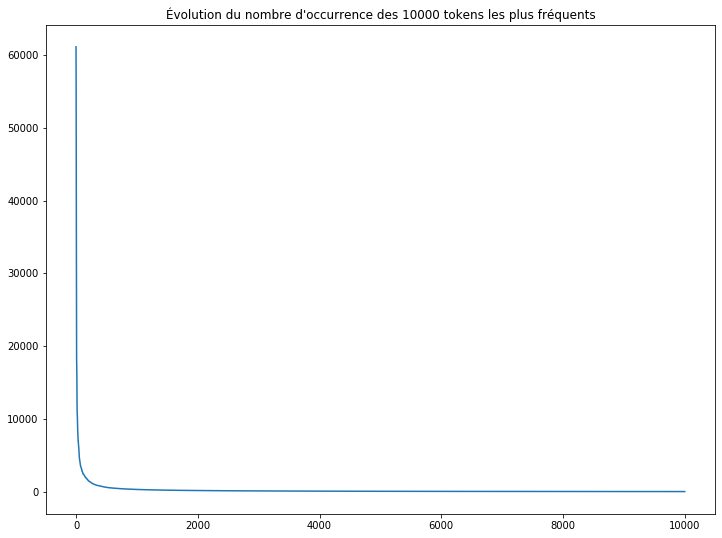

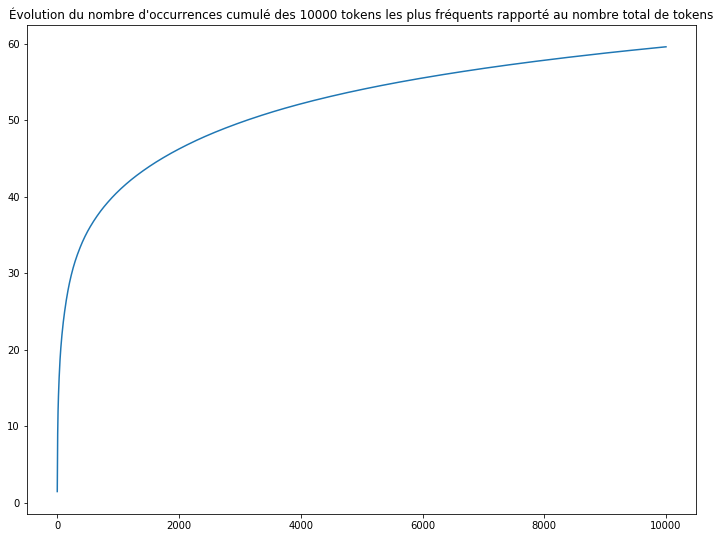

1096055
[('__UNK__', 0), ('the', 1), ('.', 2), ('~', 3), ('-', 4), ('of', 5), ('to', 6), ('and', 7), ('a', 8), ('I', 9), ('in', 10), ('1', 11), ('0', 12), ('_', 13), ('for', 14), (',', 15), ('is', 16), ('\x95', 17), ('on', 18), ('be', 19), ('that', 20), ('i', 21), ("'", 22), ('or', 23), ('NO', 24), ('by', 25), ('with', 26), ('r', 27), ('--', 28), ('The', 29), ('A', 30), ('..', 31), ('&', 32), ('2', 33), ('you', 34), ('3', 35), ('are', 36), ('this', 37), ('as', 38), ('N', 39), ('OF', 40), (':', 41), ('t', 42), ('4', 43), ('PM', 44), ('will', 45), ('/', 46), ('at', 47), ('from', 48), ('have', 49), ('not', 50), ('TO', 51), ('S', 52), ('o', 53), ('~~', 54), ('L', 55), ('C', 56), ('an', 57), ('tobacco', 58), ('AND', 59), ('THE', 60), ('your', 61), ('f', 62), ('it', 63), ('e', 64), ('7', 65), ('O', 66), ('%', 67), ('was', 68), ('s', 69), ('J', 70), ('T', 71), ('6', 72), ('Tobacco', 73), ('we', 74), ('In', 75), ('E', 76), ('l', 77), ('n', 78), ('5', 79), ('M', 80), ('---', 81), ('W', 82), ('D

In [11]:
vocabulary, _, word_count = compute_vocabulary(x_train, max_size=10**4)
plot_vocabulary(word_count, n=10000)
plot_accumulated_vocabulary(word_count, n=10000)
print(len(word_count))

print(list(vocabulary.items())[:100])

## We must reduce vocabulary size

In [0]:
def regex_preprocess(text: str) -> str:
    text = re.sub(r"([.?,!:])", r" \1 ", text.lower())  # Add an extra space before punctuation (usefull in english)
    return re.sub(r"[^ a-zA-Z0-9.?,!:$£€@#/\-\+\\\*]", " ", text)  # Remove any non basic character


@unknown_wrapped
def stop_word_tokenizer(text: str) -> Iterator[Token]:
    for word in text.split(" "):
        if not word in STOP_WORD_S:
            yield word

ALPHA = {i for i in "azertyuiopqsdfghjklmwxcvbnAZERTYUIOPQSDFGHJKLMWXCVBN"}
DIGIT = {i for i in "1234567890"}
PUNCT = {i for i in r".?,!:$£€@#/-+\*"}


__NUM__ = "__NUM__"
__PUN__ = "__PUN__"
__MIX__ = "__MIX__"
MY_SPECIALS = [__UNK__, __NUM__, __PUN__, __MIX__]


@unknown_wrapped
def special_tokenizer(text: str) -> Iterator[Token]:
    for word in text.split(" "):
        if not word in STOP_WORD_S:
            if all(c in ALPHA for c in word):
                yield word
            elif all(c in DIGIT for c in word):
                yield __NUM__
            elif all(c in PUNCT for c in word):
                yield __PUN__
            else:
                yield __MIX__


With a vocabulary of size 10000, you cover 91.00%


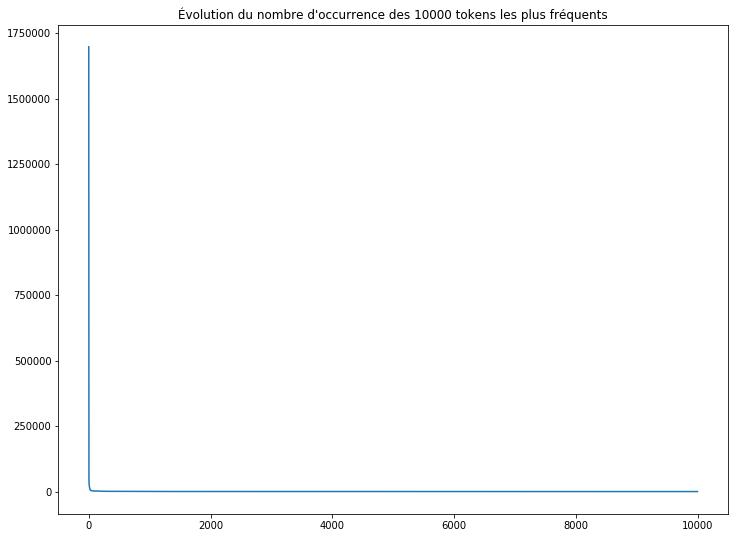

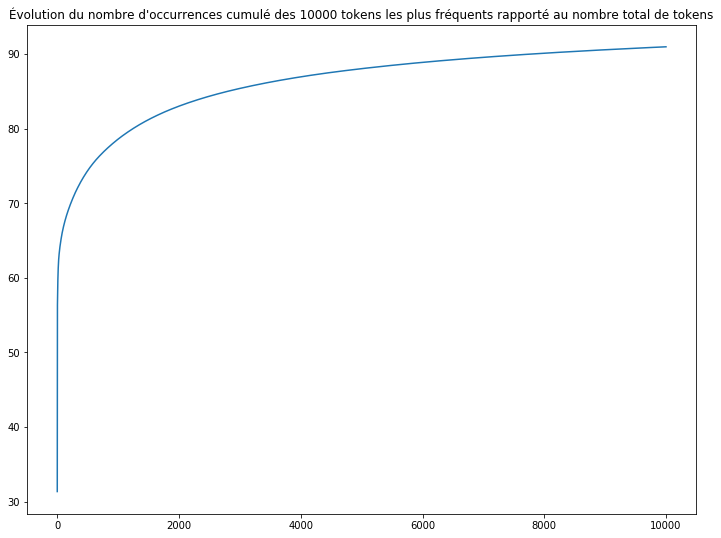

293518


In [13]:
vocabulary, _, word_count = compute_vocabulary(x_train, max_size=10**4, tokenize_f=special_tokenizer, preprocess_f=regex_preprocess, specials=MY_SPECIALS)
plot_vocabulary(word_count, n=10000)
plot_accumulated_vocabulary(word_count, n=10000)
print(len(word_count))

# Basic Model: Bag of Words


In [14]:
VOCABULARY_SIZE = 10**4

vocabulary, tokenizer_f, _ = compute_vocabulary(x_train, max_size=VOCABULARY_SIZE, tokenize_f=special_tokenizer, preprocess_f=regex_preprocess, specials=MY_SPECIALS)
vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=vocabulary, tokenizer=tokenizer_f, preprocessor=regex_preprocess, analyzer="word", binary=True)

With a vocabulary of size 10000, you cover 91.00%


In [15]:
print(vectorizer.get_feature_names())
print(regex_preprocess(x_train[0]))
print(vectorizer.fit_transform([x_train[0]]))

print(y_test)

['__UNK__', '__PUN__', '__NUM__', '__MIX__', 'r', 'c', 'l', 'n', 'e', 'f', 'j', 'w', 'p', 'pm', 'date', 'v', 'u', 'tobacco', 'b', 'g', 'x', 'h', 'z', 'q', 'k', 'new', 'total', 'number', 'company', 'box', 'inc', 'cigarette', 'co', 'please', 'smoking', 'may', 'avg', 'vol', 'subject', 'invoice', 'one', 'rjr', 'page', 'nicotine', 'york', 'would', 'reynolds', 'per', 'order', 'ii', 'name', 'amount', 'smoke', 'brand', 'product', 'code', 'camel', 'display', 'time', 'price', 'use', 'information', 'research', 'st', 'winston', 'mg', 'sent', 'us', 'form', 'miquel', 'data', 'cc', 'cigarettes', 'job', 'nir', 'morris', 'due', 'ti', 'philip', 'state', 'ecusta', 'smi', 'share', 'tar', 'ca', 'fax', 'health', 'sales', 'general', 'ny', 'il', 'copy', 'report', 'file', 'department', 'promo', 'salem', 'address', 'industry', 'size', 'group', 'program', 'mr', 'products', 'avenue', 'tax', 'nc', 'al', 'type', 'smokers', 'year', 'also', 'terv', 'description', 'pack', 'ff', 'lt', 'free', 'check', 'net', 'last', 'a

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(input_dim=VOCABULARY_SIZE, units=128, activation="relu"),
    keras.layers.Dense(units=32, activation="relu"),
    keras.layers.Dense(units=32, activation="relu"),
    keras.layers.Dense(units=NUM_CLASSES, activation="softmax"),
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["sparse_categorical_accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 1,285,477
Trainable params: 1,285,477
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(vectorizer.fit_transform(x_train), np.array(y_train), epochs=10, batch_size=64, validation_split=0.1, shuffle=True, verbose=1)

Train on 11656 samples, validate on 1296 samples
Epoch 1/10
11656/11656 [==============================] - 2s 141us/sample - loss: 1.3300 - sparse_categorical_accuracy: 0.6681 - val_loss: 1.4181 - val_sparse_categorical_accuracy: 0.3187
Epoch 2/10
11656/11656 [==============================] - 1s 113us/sample - loss: 0.6769 - sparse_categorical_accuracy: 0.8473 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.6821
Epoch 3/10
11656/11656 [==============================] - 1s 112us/sample - loss: 0.4248 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.6753 - val_sparse_categorical_accuracy: 0.7724
Epoch 4/10
11656/11656 [==============================] - 1s 116us/sample - loss: 0.3146 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.7986
Epoch 5/10
11656/11656 [==============================] - 1s 113us/sample - loss: 0.2507 - sparse_categorical_accuracy: 0.9311 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.7901
Epoch 6/10


In [18]:
model.evaluate(vectorizer.fit_transform(x_test), y_test, verbose=2)

y_pred = model.predict_classes(vectorizer.fit_transform(x_test))

print(class_names)
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

3323/3323 - 0s - loss: 0.3891 - sparse_categorical_accuracy: 0.8820
['form', 'email', 'handwritten', 'advertisement', 'invoice']
[[546  19  42  21  56]
 [ 14 639   6   5   1]
 [  9   6 570  65  17]
 [  8   1  64 588   9]
 [  9   1  24  15 588]]


# A bit more complex: Recurrent Neural Networks and Long-Short Term Memory

In [36]:
VOCABULARY_SIZE = 10**4
EMBEDDING_SIZE = 64
MAX_SEQ_LEN = 1 * 10**2

__PAD__ = "__PAD__"
PAD_SPECIALS = MY_SPECIALS + [__PAD__]

vocabulary, tokenizer_f, _ = compute_vocabulary(x_train, max_size=VOCABULARY_SIZE, tokenize_f=special_tokenizer, preprocess_f=regex_preprocess, specials=PAD_SPECIALS)

def build_vectorizer(vocabulary, tokenizer_f, preprocess_f):
    def rnn_vectorizer(x: List[InputText]):
        return [[vocabulary[token] for token in tokenizer_f(preprocess_f(text))] for text in x]
    return rnn_vectorizer

vectorizer = build_vectorizer(vocabulary, tokenizer_f, regex_preprocess)

print(vectorizer(x_test[0:2]), sep="\n")

With a vocabulary of size 10000, you cover 91.00%
[[0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 5, 0, 0, 0, 0, 0, 0, 4, 2, 152, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 8, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 203, 0, 0, 0, 2, 3, 11, 0, 0, 2, 0, 2, 0], [13, 4, 0, 0, 0, 3, 2, 3, 2, 0, 20, 2, 3, 3, 2, 3, 2, 0, 0, 0, 4, 2, 0, 2, 13, 3, 3, 3, 0]]


In [0]:
pad_f = partial(keras.preprocessing.sequence.pad_sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post", value=vocabulary[__PAD__])

rnn_x_train, rnn_x_test = map(pad_f, map(vectorizer, [x_train, x_test]))
rnn_y_train, rnn_y_test = map(np.array, [y_train, y_test])

In [38]:
model = keras.models.Sequential([
    keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQ_LEN),
    keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(128, dropout=0.5)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=NUM_CLASSES, activation="softmax")
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["sparse_categorical_accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 256)          148992    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285      
Total params: 1,086,725
Trainable params: 1,086,725
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(rnn_x_train, rnn_y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=1, shuffle=True)

Train on 11656 samples, validate on 1296 samples
Epoch 1/10
11656/11656 [==============================] - 21s 2ms/sample - loss: 1.0240 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.2492 - val_sparse_categorical_accuracy: 0.5170
Epoch 2/10
11656/11656 [==============================] - 11s 952us/sample - loss: 0.4910 - sparse_categorical_accuracy: 0.8306 - val_loss: 0.7508 - val_sparse_categorical_accuracy: 0.7600
Epoch 3/10
11656/11656 [==============================] - 11s 911us/sample - loss: 0.3435 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.7548 - val_sparse_categorical_accuracy: 0.7562
Epoch 4/10
11656/11656 [==============================] - 11s 906us/sample - loss: 0.2479 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.7084 - val_sparse_categorical_accuracy: 0.7948
Epoch 5/10
11656/11656 [==============================] - 11s 909us/sample - loss: 0.2004 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.8107 - val_sparse_categorical_accuracy: 0.7909
Epoch 6/

In [40]:
model.evaluate(rnn_x_test, rnn_y_test, verbose=2)

rnn_pred = model.predict_classes(rnn_x_test)
print(class_names)
print(sklearn.metrics.confusion_matrix(y_test, rnn_pred))

3323/1 - 4s - loss: 2.3444 - sparse_categorical_accuracy: 0.7951
['form', 'email', 'handwritten', 'advertisement', 'invoice']
[[459  30  47  55  93]
 [ 15 628  11   7   4]
 [ 15  20 457 128  47]
 [  7  24  45 572  22]
 [ 30   8  36  37 526]]


In [24]:
model = keras.models.Sequential([
    keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQ_LEN),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras_self_attention.SeqSelfAttention(attention_activation='sigmoid'),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(units=NUM_CLASSES, activation="softmax")
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["sparse_categorical_accuracy"])

model.summary()

NameError: ignored

In [0]:
model.fit(rnn_x_train, rnn_y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=1, shuffle=True)

In [0]:
model.evaluate(rnn_x_test, rnn_y_test, verbose=2)

rnn_pred = model.predict_classes(rnn_x_test)
print(class_names)
print(sklearn.metrics.confusion_matrix(y_test, rnn_pred))